In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
import torch.optim as optim
import torch.utils.data 

# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
import math

from tqdm.auto import tqdm



In [231]:
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])


In [232]:

class Flow(nn.Module):

    def invert(self, y):
        raise NotImplementedError()

    # def log_abs_det_jacobian(self, x, y):
    #     raise NotImplementedError()

    def forward(self, x, log_det_jacob):
        raise NotImplementedError()

    def __init__(self, event_dim = 1):
        # transform.Transform.__init__(self)
        nn.Module.__init__(self)
        self._event_dim = event_dim

    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

    @property
    def event_dim(self):
        return self._event_dim

    @constraints.dependent_property(is_discrete=False)
    def domain(self):
        if self.event_dim == 0:
            return constraints.real
        return constraints.independent(constraints.real, self.event_dim)

    @constraints.dependent_property(is_discrete=False)
    def codomain(self):
        if self.event_dim == 0:
            return constraints.real
        return constraints.independent(constraints.real, self.event_dim)



In [233]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
torch.tensor([1]).to(device)

tensor([1])

In [234]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, base_distrib, device):
        super().__init__()
        self.device = device
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim, self.device))
        # self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_distrib = base_distrib
        # self.final_density = distrib.TransformedDistribution(density, self.transforms)
        # self.log_det = []


    def forward(self, x):
        # Applies series of flows
        log_det_jacob = torch.zeros((x.shape[0]), device = self.device, dtype = torch.float32)
        for b in range(len(self.bijectors)):
            x, log_det_jacob = self.bijectors[b](x, log_det_jacob)
        return x, log_det_jacob

    def invert(self, z):
        for layer in reversed(self.bijectors):
            z = layer.invert(z)
        return z

    # def sample(self):
    #     # dodać cude
    #     with torch.no_grad():
    #         base_dens_samples = self.base_density.sample()
    #         out_samples, _ = self.forward(base_dens_samples)
    #     return out_samples

    # def log_prob(self, y):
    #     #dodać cude
    #     log_det_reversed_order = []
    #     for b in reversed(range(len(self.bijectors))):
    #         log_det_reversed_order.append(self.bijectors[b].log_abs_det_jacobian(y))
    #         y = self.bijectors[b]._inverse(y)
    #         print(y)
    #     log_prob_base = self.base_density.log_prob(y)
    #     jacobian_part = torch.sum(torch.stack(log_det_reversed_order))
    #     return log_prob_base - jacobian_part

class CouplingFlow(Flow):
    def __init__(self, dim, device, n_hidden=128, n_layers=3, activation=nn.ReLU, last_s_activation = nn.Tanh):
        super(CouplingFlow, self).__init__()
        self.k = dim // 2
        self.t = self.t_transform_net(self.k, self.k, n_hidden, n_layers, activation)
        self.s = self.s_transform_net(self.k, self.k, n_hidden, n_layers, activation, last_s_activation)
        self.device = device
        self.dim = dim
        # self.register_buffer("mask",torch.cat((torch.ones(self.k), torch.zeros(self.dim - self.k))).detach())
        self.init_parameters()
        # self.bijective = True


    def t_transform_net(self, n_in, n_out, n_hidden, n_layer, activation):
        net = nn.ModuleList()
        for l in range(n_layer):
            module = nn.Linear(l == 0 and n_in or n_hidden, n_hidden)
            # module.weight.data.uniform_(-1, 1)
            net.append(module)
            net.append(activation())
            if l == n_layer -1:
                module = nn.Linear(n_hidden, n_out)
                net.append(module)
        return nn.Sequential(*net)

    def s_transform_net(self, n_in, n_out, n_hidden, n_layer, activation, last_s_activation):
        net = nn.ModuleList()
        for l in range(n_layer):
            module = nn.Linear((l == 0 and n_in) or n_hidden, l == n_layer - 1 and n_out or n_hidden)
            # module.weight.data.uniform_(-1, 1)
            net.append(module)
            net.append((l == n_layer - 1 and last_s_activation()) or activation())
        return nn.Sequential(*net)

    def forward(self, x, log_det_jacob):
        x_k = x[:, 0:self.k]
        xp_D = x[:, self.k:self.dim] * torch.exp(self.s(x_k)) + self.t(x_k)
        # print(x_k.shape)
        log_det_jacob += torch.sum(torch.abs(self.s(x_k)), dim = 1)
        # xp_D = x * self.g_sig(x_k) + self.g_mu(x_k)

        return torch.cat((x_k, xp_D), dim=1), log_det_jacob


    def invert(self, y):
        yp_k = y[:, 0:self.k]
        y_D = (y[:, self.k:self.dim] - self.t(yp_k)) * torch.exp(-self.s(yp_k))
        # y_D = (((1 - self.mask) * y) - (1 - self.mask) * (self.g_mu(yp_k)) / self.g_sig(yp_k))

        return torch.cat((yp_k, y_D), dim=1)


class ReverseFlow(Flow):

    def __init__(self, dim, device):
        super(ReverseFlow, self).__init__()
        # k = dim // 2
        # self.permute = torch.cat((torch.arange(dim, k, -1),torch.arange(1, k+1, 1)))
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)
        self.device = device
        
    def forward(self, x, log_det_jacob):
        return x[:, self.permute] , log_det_jacob

    def invert(self, z):
        return z[:, self.inverse]
    


In [235]:
def nll_loss(y, log_det_jacob, base_distrib):
    log_likelihood = base_distrib.log_prob(y) + log_det_jacob
    return -torch.mean(log_likelihood)

In [236]:
from sklearn.datasets import make_moons
batch_size=256

class MoonDataset(torch.utils.data.Dataset):
    def __init__(self, device, lenght=1000):
        self.device = device
        self.lenght = lenght
        self.generate_moons(lenght)

    def generate_moons(self, lenght):
        moons_data = make_moons(lenght, noise=0.05)[0].astype("float32")
        self.moons = moons_data

    def __len__(self):
        return self.lenght

    def __getitem__(self, index):
        t = torch.tensor(self.moons[index], device = device)
        return (t)
        
my_moons = MoonDataset(device, 5000)

moons_dataloader = torch.utils.data.DataLoader(my_moons, batch_size=batch_size,
                        shuffle=False)

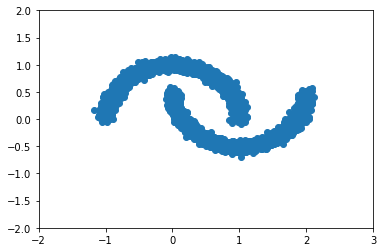

In [237]:
x = my_moons.moons
plt.scatter(x[:, 0], x[:, 1])
plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.show()

In [243]:
def train_flow(flow, data_loader, loss, optimizer, scheduler, device, epochs=10001, plot_it=1000, batch_size = 64):
    base_distrib = flow.base_distrib
    flow.to(device)
    # ims = []
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    # fig = plt.figure(figsize=(10, 10))
    # id_figure=2
    # plt.figure(figsize=(16, 18))
    # subplot_num = epochs // plot_it
    # plt.subplot((subplot_num//4) + 1,4,1)
    # plt.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    # plt.title('Target density', fontsize=15);
    # Main optimization loop
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print(f"Training epoch {epoch + 1} ...")
        loss_acc = 0.0
        flow.train()

        for i, batch in enumerate(data_loader):
            batch = batch.to(device)
            zk, log_det_jacob = flow(batch)
            loss_n = loss(zk, log_det_jacob, base_distrib)
            
            optimizer.zero_grad()
            loss_n.backward()
            # Do the step of optimizer
            optimizer.step()
            scheduler.step()
            # Gather data and report
            # loss_acc += loss_n.item() * len(batch)

        if epoch % 10 == 0:
            flow.eval()
            with torch.no_grad():
                z = base_distrib.sample((1000,))
                x = flow.invert(z).cpu()
                plt.scatter(x[:, 0], x[:, 1])
                plt.xlim(-5, 5)
                plt.ylim(-5, 5)
                plt.title(f"Epoch: {epoch + 1} nll loss: {loss_n:.4f}")
                plt.show()

In [244]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
block = [CouplingFlow, ReverseFlow]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
flow = NormalizingFlow(dim = 2, device = device, blocks = block, flow_length = 8, base_distrib = ref_distrib)
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=0.0003, weight_decay=0.001)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)

Training epoch 1 ...


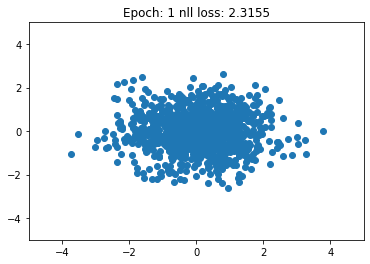

Training epoch 11 ...


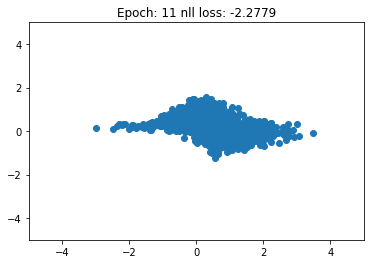

Training epoch 21 ...


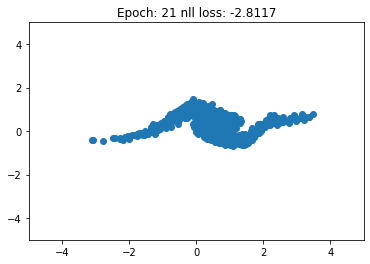

Training epoch 31 ...


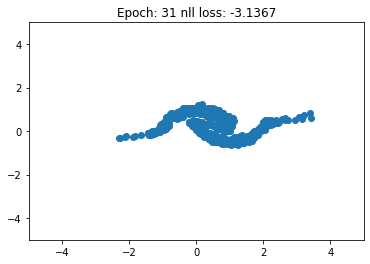

Training epoch 41 ...


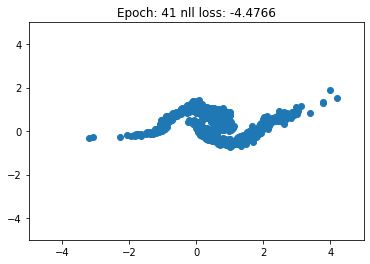

Training epoch 51 ...


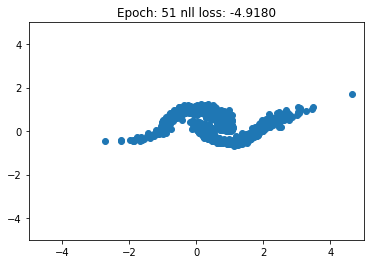

Training epoch 61 ...


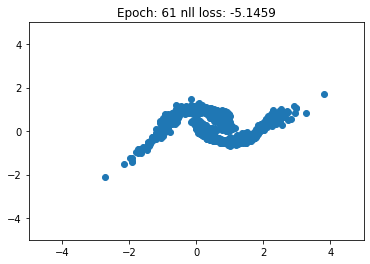

Training epoch 71 ...


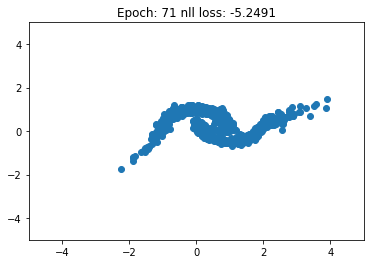

Training epoch 81 ...


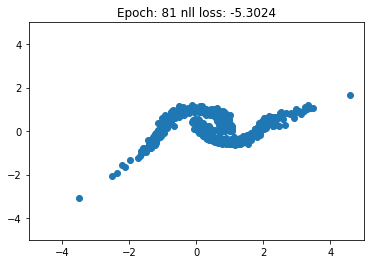

Training epoch 91 ...


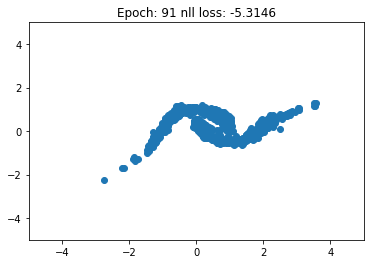

Training epoch 101 ...


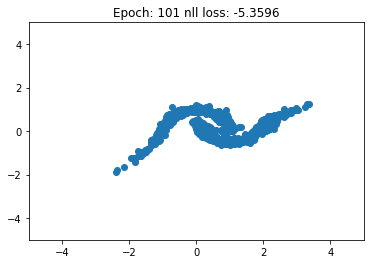

In [ ]:
train_flow(flow, moons_dataloader, nll_loss, optimizer, scheduler, device = device, epochs=300, plot_it=1000, batch_size = batch_size)